In [1]:
#download the data
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv

--2024-10-11 12:17:00--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 298573 (292K) [text/plain]
Saving to: ‘laptops.csv’

laptops.csv         100%[===================>] 291.58K   478KB/s    in 0.6s    

2024-10-11 12:17:02 (478 KB/s) - ‘laptops.csv’ saved [298573/298573]



In [3]:
#executing command line codes
# !ls
# !mv laptops.csv data/          #move the file to specific location

### Importing libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

### Data Loading

In [2]:
df=pd.read_csv('./data/laptops.csv')
print(f"Shape: {df.shape}")
df.head()

Shape: (2160, 12)


,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


### Preparing the dataset

In [3]:
# normalizing the names of the columns
df.columns=df.columns.str.lower().str.replace(' ','_')
df.columns

Index(['laptop', 'status', 'brand', 'model', 'cpu', 'ram', 'storage',
       'storage_type', 'gpu', 'screen', 'touch', 'final_price'],
      dtype='object')

In [4]:
df_mod=df[['ram', 'storage', 'screen','final_price']].copy()
df_mod.head()

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01


### EDA

<Axes: xlabel='final_price', ylabel='Count'>

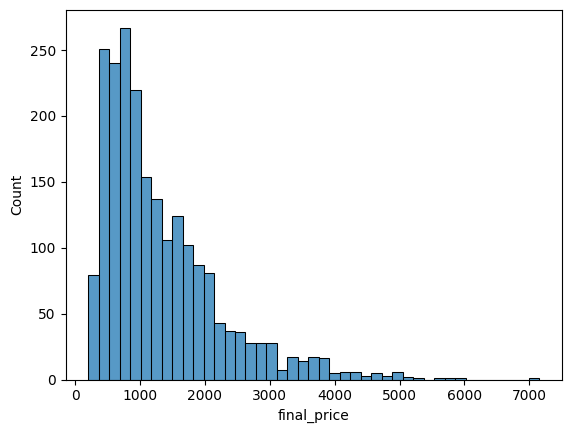

In [5]:
sns.histplot(data=df_mod,x='final_price')

It seems the final_price variable have a long tail

### Question and Answers

#### Question 1
There's one column with missing values. What is it?

In [20]:
df_mod.isnull().sum()     

#answer: screen

ram            0
storage        0
screen         4
final_price    0
dtype: int64

#### Question 2
What's the median (50% percentile) for variable 'ram'?

In [21]:
df_mod.ram.describe()

# answer: 16

count    2160.000000
mean       15.413889
std         9.867815
min         4.000000
25%         8.000000
50%        16.000000
75%        16.000000
max       128.000000
Name: ram, dtype: float64

#### Prepare and split the dataset

In [38]:
n = len(df)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

In [39]:
print(n, n_val,n_test,n_train)

2160 432 432 1296


In [40]:
idx = np.arange(n) #getting the index
print("Before shuffle")
print(idx[:10])

np.random.seed(42) #set a seed for reproducibility
np.random.shuffle(idx)  # return a shuffled array

print("After shuffle")
print(idx[:10])

Before shuffle
[0 1 2 3 4 5 6 7 8 9]
After shuffle
[2079  668 2073 1113  788 1780 1672 1717  926 2157]


In [41]:
#splitting the dataset
df_train = df_mod.iloc[idx[:n_train]]
df_val = df_mod.iloc[idx[n_train:n_train+n_val]]
df_test = df_mod.iloc[idx[n_train+n_val:]]

print(df_train.shape[0],df_val.shape[0],df_test.shape[0])

#reset the indexes
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

1296 432 432


#### Question 3
* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using round(score, 2)

Which option gives better RMSE?

In [42]:
# df_train.isnull().sum()    #3
# df_test.isnull().sum()     #0
df_val.isnull().sum()        #1

ram            0
storage        0
screen         1
final_price    0
dtype: int64

In [43]:
#separating features and target
y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values

del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

<Axes: ylabel='Count'>

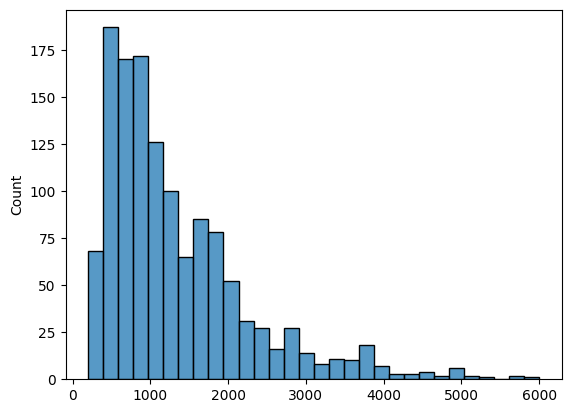

In [44]:
sns.histplot(data=y_train)

In [10]:
def train_linear_regression(X, y):
    '''
    X: Feature matrix
    y: Target vector
    Return: Tuple containing bias and weights
    '''
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]



def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [45]:
print(df_train.columns)
print(df_train.shape)

Index(['ram', 'storage', 'screen'], dtype='object')
(1296, 3)


##### Option 1 (filling with 0)

In [48]:
#Training the model and getting train score

#filling the data with 0
X_train = df_train.fillna(0).values


#getting the weights
w0, w = train_linear_regression(X_train, y_train)


#getting prediction
y_pred = w0 + X_train.dot(w)

print(f"RMSE for training data: {round(rmse(y_train, y_pred),2)}")


#getting validation score
#filling the data with 0
X_val = df_val.fillna(0).values

#getting prediction
y_pred = w0 + X_val.dot(w)

print(f"RMSE for validation data: {round(rmse(y_val, y_pred),2)}")

RMSE for training data: 602.39
RMSE for validation data: 597.36


##### Option 2 (filling with mean)

In [49]:
#Training the model and getting train score

mean_value=df_train.screen.mean()

#filling the data with mean_value
X_train = df_train.fillna(mean_value).values


#getting the weights
w0, w = train_linear_regression(X_train, y_train)


#getting prediction
y_pred = w0 + X_train.dot(w)

print(f"RMSE for training data: {round(rmse(y_train, y_pred),2)}")


#getting validation score
#filling the data with mean_value
X_val = df_val.fillna(mean_value).values

#getting prediction
y_pred = w0 + X_val.dot(w)

print(f"RMSE for validation data: {round(rmse(y_val, y_pred),2)}")

RMSE for training data: 602.18
RMSE for validation data: 600.27


Answer: with 0

#### Question 4

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0.
* Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100].
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
Which r gives the best RMSE?

In [11]:
def train_linear_regression_reg(X, y, r=0.001):
    ''' 
    X: Feature matrix
    y: Target vector
    r: Regularization factor

    Return: Tuple containing bias and weights
    '''
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])       #adding column of 1 to the matrix

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])   #adding regularization

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [51]:
#Training the model and getting train score


for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    #filling the data with 0
    X_train = df_train.fillna(0).values


    #getting the weights
    w0, w = train_linear_regression_reg(X_train, y_train,r)

    #getting validation score
    #filling the data with 0
    X_val = df_val.fillna(0).values

    #getting prediction
    y_pred = w0 + X_val.dot(w)

    print(f"RMSE for validation data for r={r}: {round(rmse(y_val, y_pred),2)}")
    print()

RMSE for validation data for r=0: 597.36

RMSE for validation data for r=0.01: 597.36

RMSE for validation data for r=0.1: 597.35

RMSE for validation data for r=1: 597.21

RMSE for validation data for r=5: 597.01

RMSE for validation data for r=10: 597.06

RMSE for validation data for r=100: 597.9



Answer: 10

#### Question 5

* We used seed 42 for splitting the data. Let's find out how ***selecting the seed*** influences our score.
* Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores.

What's the standard deviation of all the scores? To compute the standard deviation, use np.std. Round the result to 3 decimal digits (round(std, 3))

In [32]:
rmse_dict=dict()
for seed_val in [0,1,2,3,4,5,6,7,8,9]:

    #getting random indexes for a seed value
    idx = np.arange(n) #getting the index
    np.random.seed(seed_val) #set a seed for reproducibility
    np.random.shuffle(idx)  # return a shuffled array


    #splitting the dataset
    df_train = df_mod.iloc[idx[:n_train]]
    df_val = df_mod.iloc[idx[n_train:n_train+n_val]]
    df_test = df_mod.iloc[idx[n_train+n_val:]]
    # print(df_train.shape[0],df_val.shape[0],df_test.shape[0])

    #reset the indexes
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)


    #separating the targer from features
    y_train = df_train.final_price.values
    y_val = df_val.final_price.values
    y_test = df_test.final_price.values


    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']


    #Training the model and evaluate on validation dataset
    #filling the data with 0
    X_train = df_train.fillna(0).values
    X_val = df_val.fillna(0).values

    #getting the weights from training
    w0, w = train_linear_regression(X_train, y_train)

    #getting prediction on validation dataset
    y_pred = w0 + X_val.dot(w)

    print(f"RMSE for validation data for seed value {seed_val}= {round(rmse(y_val, y_pred),3)}")

    rmse_dict[seed_val]=rmse(y_val, y_pred)

RMSE for validation data for seed value 0= 565.452
RMSE for validation data for seed value 1= 636.799
RMSE for validation data for seed value 2= 588.956
RMSE for validation data for seed value 3= 597.815
RMSE for validation data for seed value 4= 571.963
RMSE for validation data for seed value 5= 573.238
RMSE for validation data for seed value 6= 647.344
RMSE for validation data for seed value 7= 550.44
RMSE for validation data for seed value 8= 587.334
RMSE for validation data for seed value 9= 576.102


In [33]:
#getting standard deviation
round(np.std(list(rmse_dict.values())),3)


#answer: 29.176

np.float64(29.176)

#### Question 6

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with r=0.001.   


What's the RMSE on the test dataset?

In [36]:
#getting random indexes for a seed value
idx = np.arange(n) #getting the index
np.random.seed(9) #set a seed for reproducibility
np.random.shuffle(idx)  # return a shuffled array


#splitting the dataset
df_train = df_mod.iloc[idx[:n_train]]
df_val = df_mod.iloc[idx[n_train:n_train+n_val]]
df_test = df_mod.iloc[idx[n_train+n_val:]]
# print(df_train.shape[0],df_val.shape[0],df_test.shape[0])

#combining train and validation dataset
df_full_train=pd.concat([df_train,df_val])

#reset the indexes
df_full_train = df_full_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

#separating the targer from features
y_full_train = df_full_train.final_price.values
y_test = df_test.final_price.values


del df_full_train['final_price']
del df_test['final_price']


#Training the model and evaluate on test dataset
#filling the data with 0
X_full_train = df_full_train.fillna(0).values
X_test = df_test.fillna(0).values



#getting the weights from training
w0, w = train_linear_regression_reg(X_full_train, y_full_train,r=0.001)

#getting prediction on validation dataset
y_pred = w0 + X_test.dot(w)

print(f"RMSE for test data for seed value {seed_val}= {rmse(y_test, y_pred)}")

RMSE for test data for seed value 9= 608.609982204956


Answer: 608.61